In [1]:
from numpy.linalg import qr, svd

from scipy.linalg import subspace_angles

import math

import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax

from kernel_sca_inducing_points import *
from utils import *
from kernels import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import CCA


CCA and ZETA

In [2]:
def get_CCA(U, V, d):
    U = U.swapaxes(1,2).reshape(-1, d) 
    V = V.swapaxes(1,2).reshape(-1, d)

    cca = CCA(n_components=d)
    cca.fit(U, V)
    U_c, V_c = cca.transform(U, V)
    corrs = [np.corrcoef(U_c[:, i], V_c[:, i])[0, 1] for i in range(d)]  
    return np.mean(corrs)

ds = np.arange(2,11)
ls_zeta_pca = []
ls_zeta_sca = []
ls_zeta_ksca = []

ls_CCA_sca_ksca = []
ls_CCA_pca_ksca = []
ls_CCA_pca_sca = []
for d in ds:
    Y_pca = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/FINAL/pca_spikes/Y_pca_{d}d.npy')
    Y_sca = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/FINAL/neural_spikes_linear_pcaFalse/Y_{d}d.npy')
    Y_ksca = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/FINAL/neural_spikes_kernel_pcaFalse/projection_{d}d_gaussian.npy')

    ls_zeta_pca.append(compute_S_all_pairs(jnp.array(Y_pca)))
    ls_zeta_sca.append(compute_S_all_pairs(jnp.array(Y_sca)))
    ls_zeta_ksca.append(compute_S_all_pairs(jnp.array(Y_ksca)))
   
    ls_CCA_sca_ksca.append(get_CCA(Y_sca, Y_ksca, d)) 
    ls_CCA_pca_ksca.append(get_CCA(Y_pca, Y_ksca, d)) 
    ls_CCA_pca_sca.append(get_CCA(Y_pca, Y_sca, d)) 


/Users/ariellerosinski/miniforge3/envs/sca_project/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/Users/ariellerosinski/miniforge3/envs/sca_project/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


In [3]:
main_path = '/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/FINAL/RESULTS/SPIKES'

np.save(f'{main_path}/ls_zeta_pca', ls_zeta_pca)
np.save(f'{main_path}/ls_zeta_sca', ls_zeta_sca)
np.save(f'{main_path}/ls_zeta_ksca', ls_zeta_ksca)
np.save(f'{main_path}/ls_CCA_sca_ksca', ls_CCA_sca_ksca)
np.save(f'{main_path}/ls_CCA_pca_ksca', ls_CCA_pca_ksca)
np.save(f'{main_path}/ls_CCA_pca_sca', ls_CCA_pca_sca)

VAR EXPLAINED 

In [2]:
#A_train = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_test/A_train_softNormMax_centerFalse_pcaFalse.npy')
#A_test = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_test/A_test_softNormMax_centerFalse_pcaFalse.npy')

A = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/A_softNormMax_centerFalse_pcaFalse_spikes.npy')

ls_var_pca = []
ls_var_sca = []
ls_var_ksca = []
ds = np.arange(2,11)
for d in ds:
    # X_train = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_test/X_train_softNormMax_centerTrue_pcaFalse_spikes.npy')
    # X_test = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_test/X_test_softNormMax_centerTrue_pcaFalse_spikes.npy')
    
    X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/X_softNormMax_centerTrue_pcaFalse_spikes.npy')

    PCs = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/FINAL/pca_spikes/PCs_{d}d.npy')
    var_pca = var_explained(X, PCs.T)
    ls_var_pca.append(var_pca)

    U = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/FINAL/neural_spikes_linear_pcaFalse/U_{d}d.npy')
    U_qr, _ = jnp.linalg.qr(U)   
    var_sca = var_explained(X, U_qr)
    ls_var_sca.append(var_sca)

    
    # X_train = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_test/X_train_softNormMax_centerFalse_pcaFalse.npy')
    # X_test = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_test/X_test_softNormMax_centerFalse_pcaFalse.npy')
    
    # X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/X_softNormMax_centerFalse_pcaFalse_spikes.npy')

    # params = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/FINAL/neural_spikes_kernel_pcaFalse/params_{d}d_gaussian.npy', allow_pickle=True).tolist()
    # _, _, _, _, alpha  = get_alpha(params, A, X, K_X_Y_squared_exponential, d)
    # _, _, l2, scale = get_params(params, kernel_function=K_X_Y_squared_exponential)

    # var_ksca = var_explained_kernel(alpha, K_X_Y_squared_exponential, A, X, l2, scale, compute_matrix=False)
    # ls_var_ksca.append(var_ksca)
   


In [3]:
main_path = '/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/FINAL/RESULTS/SPIKES'

np.save(f'{main_path}/ls_var_pca', ls_var_pca)
np.save(f'{main_path}/ls_var_sca', ls_var_sca)
#np.save(f'{main_path}/ls_var_ksca', ls_var_ksca)

In [ ]:
# VAR kSCA #
A = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/A_softNormMax_centerFalse_pcaFalse_spikes.npy')
X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/X_softNormMax_centerFalse_pcaFalse_spikes.npy')


d = 2
params = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/FINAL/neural_spikes_kernel_pcaFalse/params_{d}d_gaussian.npy', allow_pickle=True).tolist()
_, _, _, _, alpha  = get_alpha(params, A, X, K_X_Y_squared_exponential, d)
_, _, l2, scale = get_params(params, kernel_function=K_X_Y_squared_exponential)

var_ksca = var_explained_kernel(alpha, K_X_Y_squared_exponential, A, X, l2, scale, compute_matrix=False)
np.save(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/FINAL/RESULTS/SPIKES/var_ksca/var_ksca_{d}d')

In [ ]:
var_ksca

In [4]:
ls_var_pca

[0.07690458695649924,
 0.10692695033292234,
 0.12932532848209136,
 0.1495807756612885,
 0.16802658837635898,
 0.1850357513318384,
 0.20051112041852712,
 0.21394327429496718,
 0.22655369988549287]

In [5]:
ls_var_sca

[0.06214795348114796,
 0.07561901484399401,
 0.08325094086929932,
 0.09023690076763703,
 0.135947722188963,
 0.14296174134209838,
 0.1497918524586758,
 0.17043141337115472,
 0.16826602461876436]

In [110]:
ls_var_ksca

[Array(0.11116104, dtype=float32),
 Array(0.13550976, dtype=float32),
 Array(0.14758231, dtype=float32),
 Array(0.15918608, dtype=float32),
 Array(0.24819452, dtype=float32),
 Array(0.25879577, dtype=float32),
 Array(0.27632034, dtype=float32),
 Array(0.28750739, dtype=float32),
 Array(0.2948949, dtype=float32)]

Linear Regression

In [2]:
# behaviour_ = 'aug_behaviour'
# behaviour = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/behaviour/{behaviour_}.npy')
behaviour = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_behavior.npy').swapaxes(1,2)
split = 200
lag = 5

ls_r2_ksca = []
ls_r2_sca = []
ls_r2_pca = []
ds = np.arange(2,11)

y_train = behaviour[split:,:,lag:].swapaxes(1,2).reshape(-1, behaviour.shape[1])
y_test = behaviour[:split,:,lag:].swapaxes(1,2).reshape(-1, behaviour.shape[1])
for d in ds:
    Y_pca = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/FINAL/pca_spikes/Y_pca_{d}d.npy')
    Y_sca = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/FINAL/neural_spikes_linear_pcaFalse/Y_{d}d.npy')
    Y_ksca = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/FINAL/neural_spikes_kernel_pcaFalse/projection_{d}d_gaussian.npy')

    X_train = Y_ksca[split:,:,:-lag].swapaxes(1,2).reshape(-1, d)
    X_test = Y_ksca[:split,:,:-lag].swapaxes(1,2).reshape(-1, d)
    ls_r2_ksca.append( get_reg(X_train,y_train,X_test, y_test)[0] )

    X_train = Y_sca[split:,:,:-lag].swapaxes(1,2).reshape(-1, d)
    X_test = Y_sca[:split,:,:-lag].swapaxes(1,2).reshape(-1, d)
    ls_r2_sca.append( get_reg(X_train,y_train,X_test, y_test)[0] )


    X_train = Y_pca[split:,:,:-lag].swapaxes(1,2).reshape(-1, d)
    X_test = Y_pca[:split,:,:-lag].swapaxes(1,2).reshape(-1, d)
    ls_r2_pca.append( get_reg(X_train,y_train,X_test, y_test)[0] )


#X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/psth.npy').swapaxes(1,2)
X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_spksmth.npy').swapaxes(1,2)
X_train = X[split:,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])
X_test = X[:split,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])
r2_X = get_reg(X_train,y_train,X_test, y_test)[0]

In [3]:
main_path = '/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/FINAL/RESULTS/SPIKES'

behaviour_ = 'hand_vel'
np.save(f'{main_path}/ls_r2_pca_{behaviour_}', ls_r2_pca)
np.save(f'{main_path}/ls_r2_sca_{behaviour_}', ls_r2_sca)
np.save(f'{main_path}/ls_r2_ksca_{behaviour_}', ls_r2_ksca)
np.save(f'{main_path}/r2X_{behaviour_}', r2_X)

# np.save(f'{main_path}/ls_r2_pca_{behaviour_}', ls_r2_pca)
# np.save(f'{main_path}/ls_r2_sca_{behaviour_}', ls_r2_sca)
# np.save(f'{main_path}/ls_r2_ksca_{behaviour_}', ls_r2_ksca)
# np.save(f'{main_path}/r2X_{behaviour_}', r2_X)

ENDS HERE 

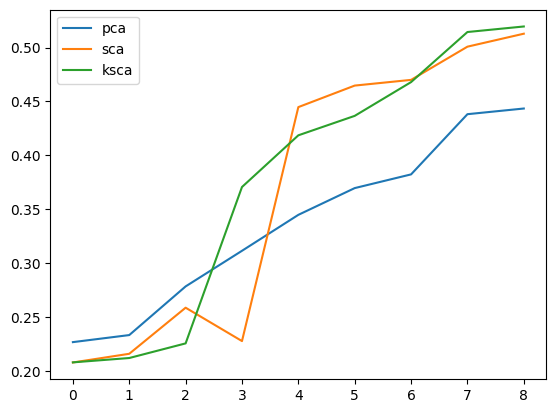

In [4]:
plt.figure()
plt.plot(ls_r2_pca, label='pca')
plt.plot(ls_r2_sca, label='sca')
plt.plot(ls_r2_ksca, label='ksca')
plt.legend()

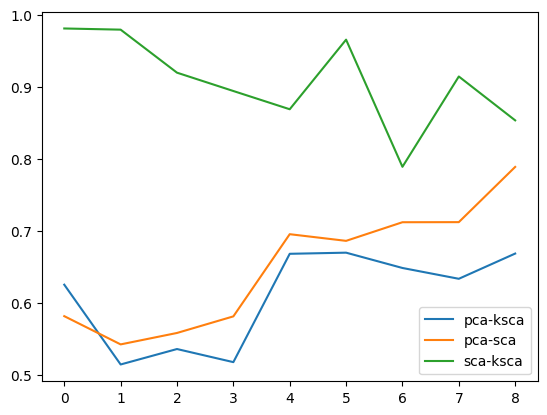

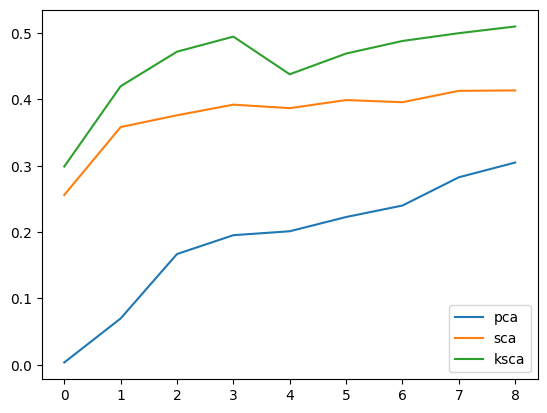

In [97]:
plt.plot(ls_CCA_pca_ksca, label='pca-ksca')
plt.plot(ls_CCA_pca_sca, label='pca-sca')
plt.plot(ls_CCA_sca_ksca, label='sca-ksca')
plt.legend()

plt.figure()
plt.plot(ls_zeta_pca, label='pca')
plt.plot(ls_zeta_sca, label='sca')
plt.plot(ls_zeta_ksca, label='ksca')
plt.legend()